In [69]:
import pandas as pd
import numpy as np

#my functions:
from invest_func import *

lt = ["MSFT","GM","BMW.DE","AAPL","NFLX","IBM"]
Company_Data = fin_data_points(lt)

In [70]:
Company_Data

,P/B,P/E,D/E,ROE,ROA,NetProfit,GrossProfit,EBIT,ProfitMargin,ForwardDividendYeild,Name,Industry,Sector,Country,Currency
MSFT,16.2549,13.7309,1.35,47.08%,13.76%,168088000000,115856000000,69916000000,36.45%,0.80%,Microsoft Corporation,Software—Infrastructure,Technology,United States,USD
GM,1.6853,0.6835,3.73,24.88%,3.92%,122485000000,14502000000,8559000000,9.13%,NaN,General Motors Company,Auto Manufacturers,Consumer Cyclical,United States,USD
BMW.DE,0.8925,0.5547,2.52,17.37%,3.43%,98990000000,12211000000,4837000000,9.93%,2.22%,Bayerische Motoren Werke Aktiengesellschaft,Auto Manufacturers,Consumer Cyclical,Germany,EUR
AAPL,37.7615,8.9878,3.96,127.13%,19.30%,274515000000,104956000000,66288000000,25.00%,0.59%,Apple Inc.,Consumer Electronics,Technology,United States,USD
NFLX,25.0048,11.0691,2.55,NaN,NaN,24996056000,9719737000,4585289000,17.64%,NaN,"Netflix, Inc.",Entertainment,Communication Services,United States,USD
IBM,6.1366,1.7276,6.53,24.53%,3.84%,73621000000,35575000000,8584000000,7.17%,4.62%,International Business Machines Corporation,Information Technology Services,Technology,United States,USD


In [72]:
Fin_Data = Company_Data.loc[:,'P/B':'ForwardDividendYeild']
Fin_Data.style.apply(highlight_thebest_fin)

,P/B,P/E,D/E,ROE,ROA,NetProfit,GrossProfit,EBIT,ProfitMargin,ForwardDividendYeild
MSFT,16.254900,13.730900,1.350000,47.08%,13.76%,168088000000,115856000000,69916000000,36.45%,0.80%
GM,1.685300,0.683500,3.730000,24.88%,3.92%,122485000000,14502000000,8559000000,9.13%,nan
BMW.DE,0.892500,0.554700,2.520000,17.37%,3.43%,98990000000,12211000000,4837000000,9.93%,2.22%
AAPL,37.761500,8.987800,3.960000,127.13%,19.30%,274515000000,104956000000,66288000000,25.00%,0.59%
NFLX,25.004800,11.069100,2.550000,nan,nan,24996056000,9719737000,4585289000,17.64%,nan
IBM,6.136600,1.727600,6.530000,24.53%,3.84%,73621000000,35575000000,8584000000,7.17%,4.62%


In [73]:
#display general info
INFO_Data = Company_Data.loc[:,'Name':'Currency']
print(INFO_Data)

                                               Name  \
MSFT                          Microsoft Corporation   
GM                           General Motors Company   
BMW.DE  Bayerische Motoren Werke Aktiengesellschaft   
AAPL                                     Apple Inc.   
NFLX                                  Netflix, Inc.   
IBM     International Business Machines Corporation   

                               Industry                  Sector  \
MSFT            Software—Infrastructure              Technology   
GM                   Auto Manufacturers       Consumer Cyclical   
BMW.DE               Auto Manufacturers       Consumer Cyclical   
AAPL               Consumer Electronics              Technology   
NFLX                      Entertainment  Communication Services   
IBM     Information Technology Services              Technology   

              Country Currency  
MSFT    United States      USD  
GM      United States      USD  
BMW.DE        Germany      EUR  
AAPL    Unit

In [74]:
period = 10

pricies_daily = yfin_dprices(lt, period)
returns_daily = yfin_dreturns(lt,period)

df = pricies_daily

# Display a brief summary of the dataset 
price_stat = pricies_daily.describe().T
display(price_stat)

,count,mean,std,min,25%,50%,75%,max
MSFT,2516.0,87.976720,72.816986,19.704592,34.641654,53.797424,120.301003,308.230011
GM,2516.0,30.875078,9.472491,14.530401,25.624737,29.189846,35.007341,63.919998
BMW.DE,2468.0,62.200051,11.824225,32.825813,55.804556,62.916800,69.718670,95.889999
AAPL,2516.0,44.380868,36.131477,11.148829,20.404609,28.873722,50.255406,156.690002
NFLX,2516.0,199.485982,174.983024,7.685714,52.091786,122.895000,344.552498,639.099976
IBM,2516.0,128.065891,12.084401,87.785240,120.385828,127.527378,138.185719,155.979523


In [75]:
# Recheck data
print(df.isnull().values.any())

True


In [76]:
df.count()

MSFT      2516
GM        2516
BMW.DE    2468
AAPL      2516
NFLX      2516
IBM       2516
dtype: int64

In [77]:
#display % of None data
df.isnull().sum()/df.count()*100

MSFT      0.000000
GM        0.000000
BMW.DE    1.944895
AAPL      0.000000
NFLX      0.000000
IBM       0.000000
dtype: float64

In [78]:
df.tail()

,MSFT,GM,BMW.DE,AAPL,NFLX,IBM
2021-10-14,302.750000,57.689999,86.360001,143.759995,633.799988,143.389999
2021-10-15,304.209991,58.000000,87.559998,144.839996,628.289978,144.610001
2021-10-18,307.290009,56.889999,86.370003,146.550003,637.969971,142.320007
2021-10-19,308.230011,56.849998,85.459999,148.759995,639.000000,141.979996
2021-10-20,307.410004,57.669998,84.669998,149.259995,625.140015,141.899994


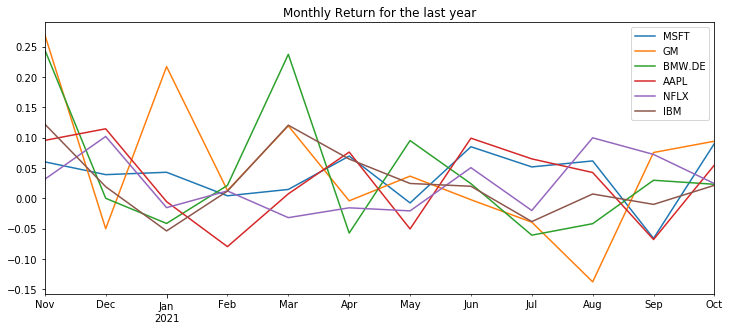

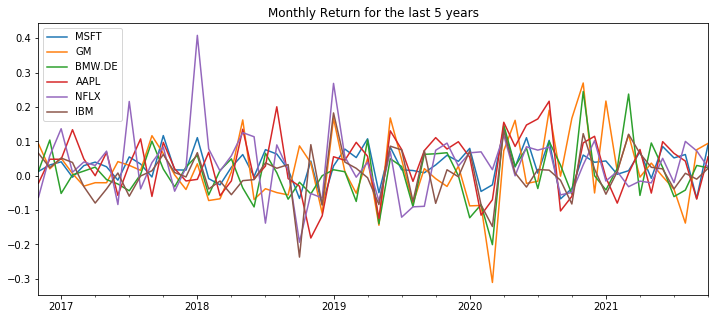

In [79]:
# Monthly return for the last year and for the last 5 years
returns_monthly= yfin_mreturns(lt,period)
returns_monthly.tail(12).plot(figsize = (12,5), title = 'Monthly Return for the last year')
returns_monthly.tail(12 *5).plot(figsize = (12,5), title = 'Monthly Return for the last 5 years')

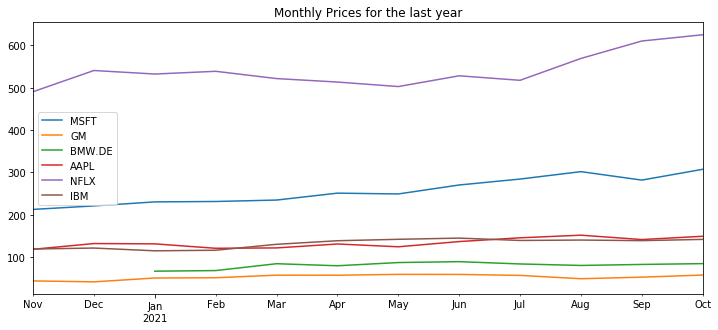

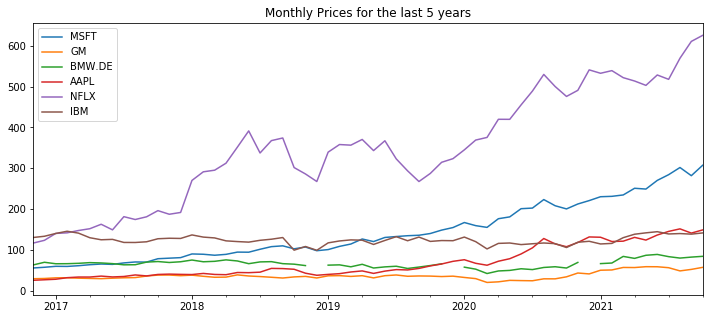

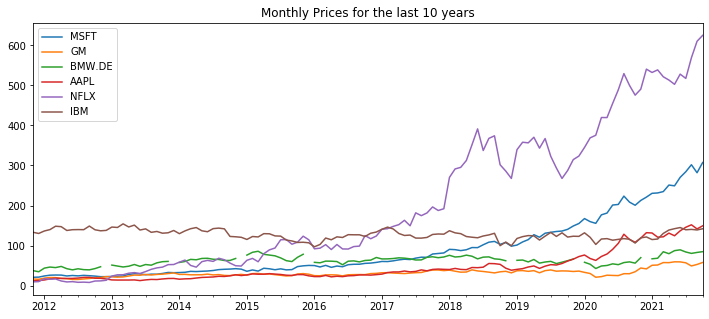

In [80]:
# Monthly prices for the last year, 5 and 10 years
pricies_monthly = yfin_mprices(lt,10)
pricies_monthly.tail(12).plot(figsize = (12,5), title = 'Monthly Prices for the last year')
pricies_monthly.tail(12 * 5).plot(figsize = (12,5), title = 'Monthly Prices for the last 5 years')
pricies_monthly.tail(12 * 10).plot(figsize = (12,5), title = 'Monthly Prices for the last 10 years')

In [83]:
# Display summary statistic
Summary_Statistic(lt,10)

,"Annualize Returns(,%)","Annualize Volatility(,%)",Annual Sharpe Ratio,Max Drawdown(%),Rating Returns,SR rating
IBM,1.03,22.27,0.15,-43.12,⭐,
BMW.DE,8.29,28.29,0.44,-57.62,⭐,
GM,11.80,34.43,0.53,-56.44,⭐,
NFLX,43.44,52.65,1.19,-57.36,⭐⭐⭐,
AAPL,28.50,27.22,1.22,-43.64,⭐⭐,
MSFT,30.13,22.17,1.50,-25.69,⭐⭐,🔥


In [84]:
# Todays prices from the max price for the last 10 years ( in %)
df = pricies_daily
df.tail(1)/price_stat['max']*100

,MSFT,GM,BMW.DE,AAPL,NFLX,IBM
2021-10-20,99.733963,90.222152,88.299091,95.258148,97.815684,90.973476


In [85]:
# Todays prices
df.tail(1)

,MSFT,GM,BMW.DE,AAPL,NFLX,IBM
2021-10-20,307.410004,57.669998,84.669998,149.259995,625.140015,141.899994
